In [1]:
# Import
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the Dataset
df = pd.read_csv("dmu-work/test.csv")

In [3]:
print(df.isnull().sum())

version      0
file         0
has_smell    0
dtype: int64


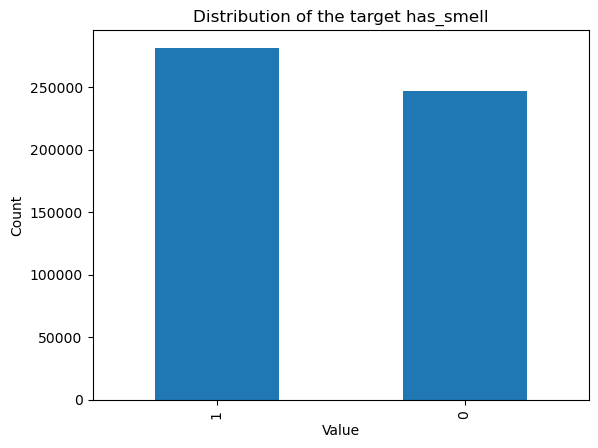

In [4]:
df["has_smell"].value_counts().plot(kind="bar")
plt.title("Distribution of the target has_smell")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [5]:
# Encoding categorical data
categorical_features = ["version", "file"]
target_feature = "has_smell"

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_encoder, categorical_features)
    ],
    remainder='drop'
)

X = preprocessor.fit_transform(df[categorical_features])
y = df[target_feature].values

In [6]:
# Splitting the dataset into the Training set and the Test set
split_idx = int(0.8 * len(df))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [7]:
# Feature scaling
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [8]:
# ANN Model

In [9]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [10]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ann_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[callback])

Epoch 1/100
10567/10567 [==============================] - 124s 11ms/step - loss: 0.0716 - accuracy: 0.9695 - val_loss: 0.7764 - val_accuracy: 0.8562
Epoch 2/100
10567/10567 [==============================] - 102s 10ms/step - loss: 0.0241 - accuracy: 0.9901 - val_loss: 0.9912 - val_accuracy: 0.8468
Epoch 3/100
10567/10567 [==============================] - 101s 10ms/step - loss: 0.0154 - accuracy: 0.9939 - val_loss: 0.9554 - val_accuracy: 0.8599
Epoch 4/100
10567/10567 [==============================] - 100s 9ms/step - loss: 0.0108 - accuracy: 0.9957 - val_loss: 0.9950 - val_accuracy: 0.8466
Epoch 5/100
10567/10567 [==============================] - 102s 10ms/step - loss: 0.0081 - accuracy: 0.9968 - val_loss: 0.9678 - val_accuracy: 0.8506
Epoch 6/100
10567/10567 [==============================] - 107s 10ms/step - loss: 0.0062 - accuracy: 0.9975 - val_loss: 0.8089 - val_accuracy: 0.8539
Epoch 7/100
10567/10567 [==============================] - 106s 10ms/step - loss: 0.0052 - accuracy: 

In [12]:
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype(int).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print("Classification Report:\n", classification_report(y_test, y_pred_ann))

3303/3303 [==============================] - 3s 859us/step
Accuracy: 0.9279542723031352
Confusion Matrix:
 [[35814   773]
 [ 6840 62242]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90     36587
           1       0.99      0.90      0.94     69082

    accuracy                           0.93    105669
   macro avg       0.91      0.94      0.92    105669
weighted avg       0.94      0.93      0.93    105669



In [13]:
# Random Forest Model

In [14]:
forest_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_forest))
print("Classification Report:\n", classification_report(y_test, y_pred_forest))

Accuracy: 0.8631670594024737
Confusion Matrix:
 [[36124   463]
 [13996 55086]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.99      0.83     36587
           1       0.99      0.80      0.88     69082

    accuracy                           0.86    105669
   macro avg       0.86      0.89      0.86    105669
weighted avg       0.90      0.86      0.87    105669



In [16]:
# Code stacking (SVR)

In [17]:
# Créer les ebtrées du modèle d'ensemble (stacking)
ann_preds = ann_model.predict(X_test).flatten()
forest_preds = forest_model.predict(X_test)
stacked_inputs = np.column_stack((ann_preds, forest_preds))

3303/3303 [==============================] - 2s 729us/step


In [18]:
# Entrîner le modèle méta (SVR)
meta_model = SVR()
meta_model.fit(stacked_inputs, y_test)

SVR()

In [19]:
# Prédictions finales
final_preds = meta_model.predict(stacked_inputs)

In [20]:
# Evaluation
mse = mean_squared_error(y_test, final_preds)
print("MSE du modèle de stacking (SVR):", mse)
print("Prédictions (extrait):", final_preds[:10])

MSE du modèle de stacking (SVR): 0.06468571487634342
Prédictions (extrait): [0.91023014 0.90059995 0.91023014 0.10009687 0.91023014 0.91023014
 0.91023014 0.91023014 0.89980178 0.91023014]


In [21]:
final_preds_binary = (final_preds >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, final_preds_binary)
print("Accuracy stacking SVR :", accuracy)

# Evaluation complète
print("Confusing Maxtric:\n", confusion_matrix(y_test, final_preds_binary))
print("Classification Report:\n", classification_report(y_test, final_preds_binary))

Accuracy stacking SVR : 0.9293170182361904
Confusing Maxtric:
 [[35726   861]
 [ 6608 62474]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.91     36587
           1       0.99      0.90      0.94     69082

    accuracy                           0.93    105669
   macro avg       0.92      0.94      0.92    105669
weighted avg       0.94      0.93      0.93    105669

